In [1]:
import cv2
import numpy as np, matplotlib.pyplot as plt
from cvflow import *
import laneFindingPipeline, utils
%matplotlib inline

In [2]:
getattr(Constant('zeros'), 'theConstant', None) == 'zeros'

True

In [3]:
from utils import show

In [4]:
allFrames = laneFindingPipeline.utils.loadFrames(maxframes=100)

HBox(children=(IntProgress(value=0, description='load project: ', max=1260), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load challenge: ', max=484), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load harder_challenge: ', max=1199), HTML(value='')))

In [5]:
class HSVshow(Pipeline):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        undistort = Undistort(self.input)
        perspective = Perspective(undistort)
        hsv = CvtColor(perspective, cv2.COLOR_RGB2HSV)
        s, v = [ColorSplit(hsv, k) for k in range(1, 3)]
#         s_binary = CountSeekingThreshold(s, goalCount=11000)
#         v_binary = CountSeekingThreshold(v, goalCount=11000)
        s_sharp = UnsharpMask(s)
        s_binary = SobelClip(
            s_sharp, narrowIterations=5, wideIterations=16, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=13000,
            )
        )
        self.vdilateSobel = DilateSobel(v, dilationIterations=10)
        self.vdilateSobelInv = DilateSobel(self.vdilateSobel, dilationIterations=10)
        
        v_binary = SobelClip(
            v, narrowIterations=10, wideIterations=20, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=19000,
            )
        )        
        self.output = s_binary | v_binary
        self.includeInMultistep([
            undistort, perspective, hsv, s, v, #h,
            self.vdilateSobel, self.vdilateSobelInv,
            s_sharp,
            s_binary, v_binary,
        ])

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

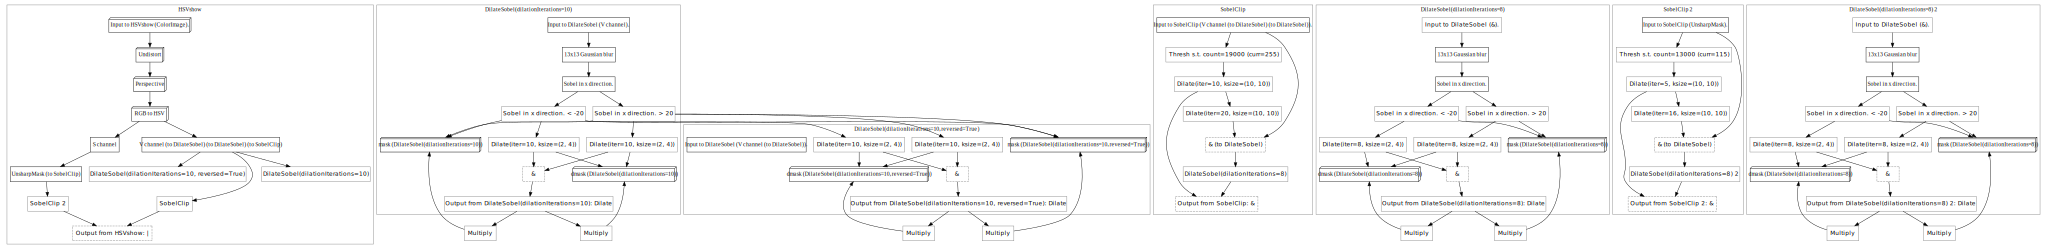

In [6]:
frame = allFrames['harder_challenge'][-12]
hsvshow = HSVshow()
hsvshow(frame)
hsvshow.assembleGraph()
hsvshow.draw(addKey=False)

(<matplotlib.figure.Figure at 0x7fe393583978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe393594400>)

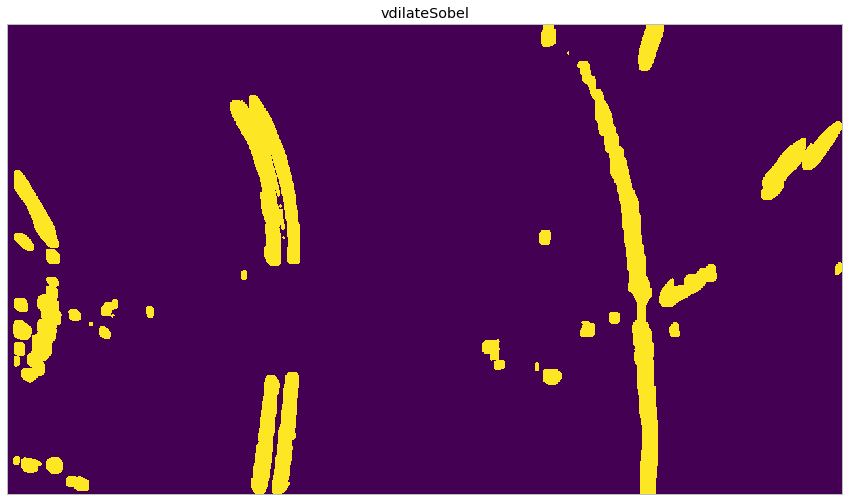

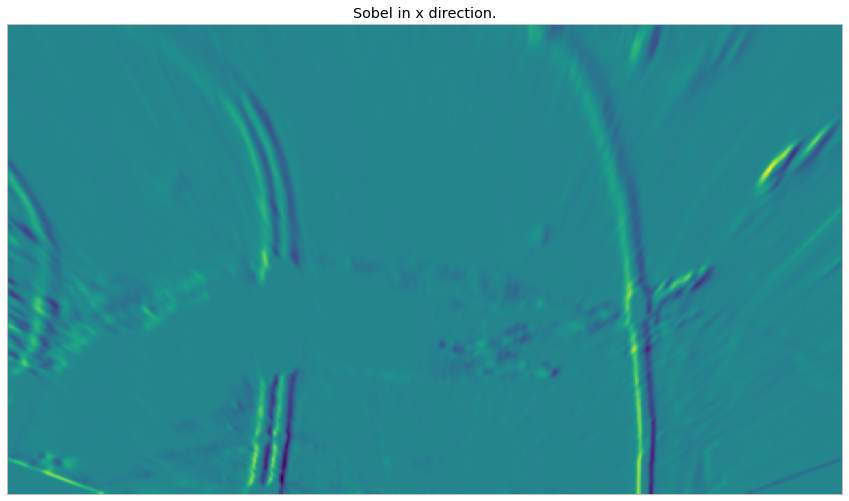

In [7]:
sobel = list(hsvshow.getByKind(Sobel))[0]
vdilateSobel = hsvshow.vdilateSobel

v = vdilateSobel.value
fig, ax = plt.subplots(figsize=(16,9))
show(v, ax=ax, title='vdilateSobel')

v = sobel.value
fig, ax = plt.subplots(figsize=(16,9))
show(v, ax=ax, title=sobel)

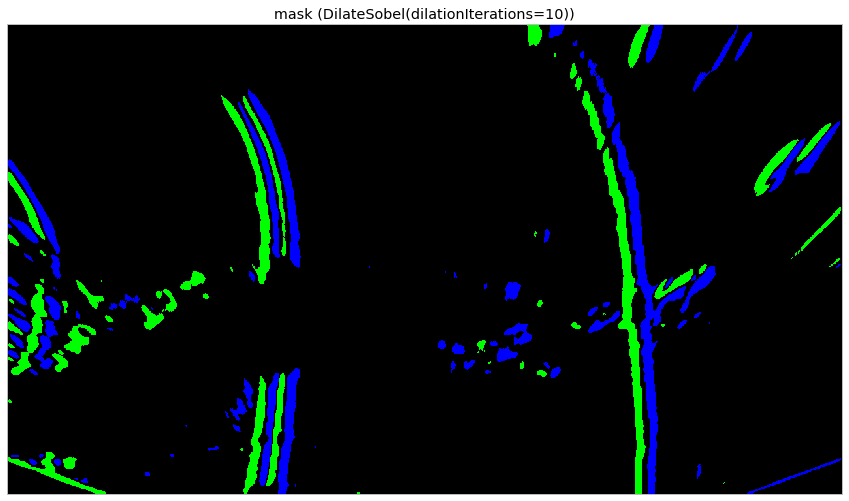

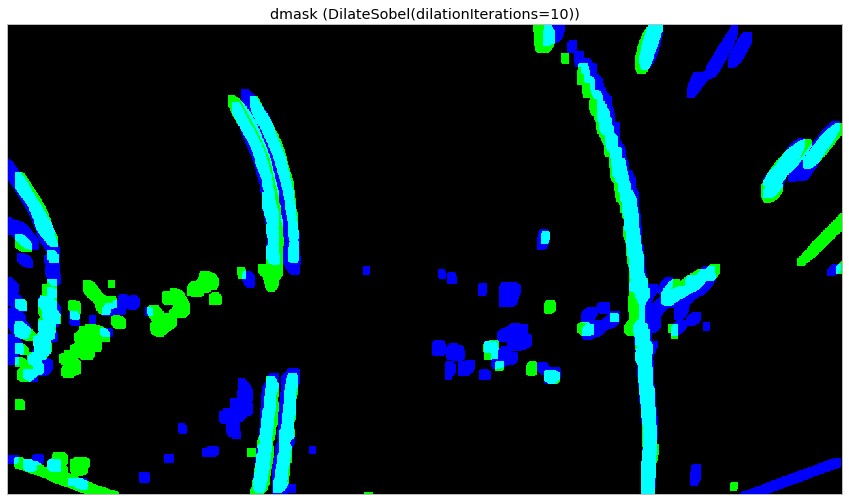

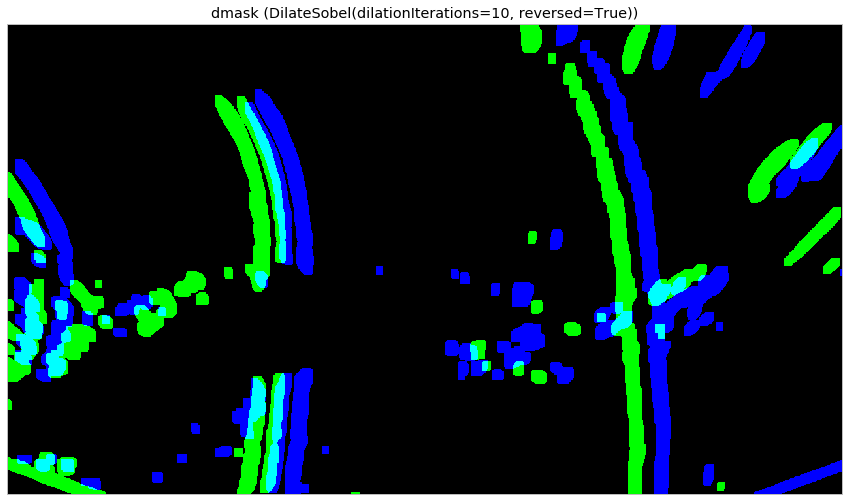

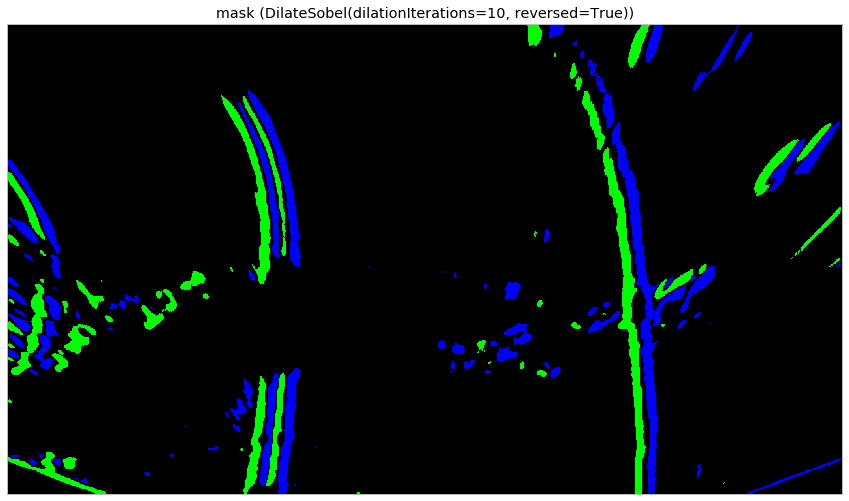

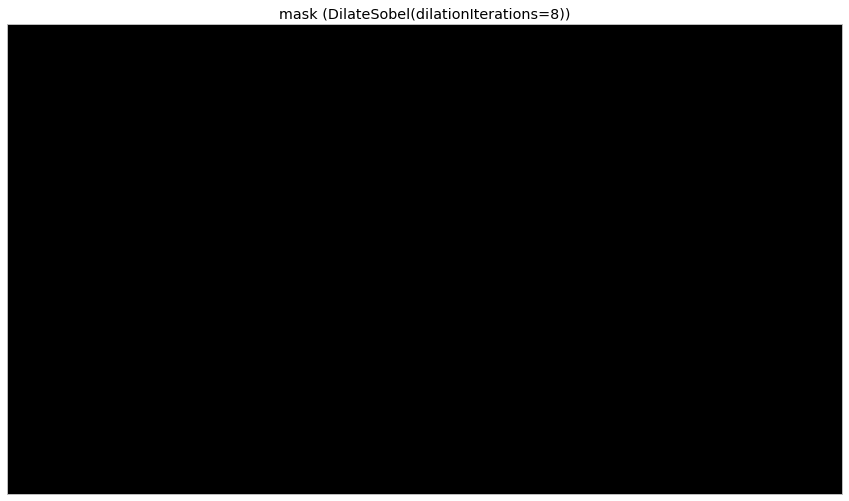

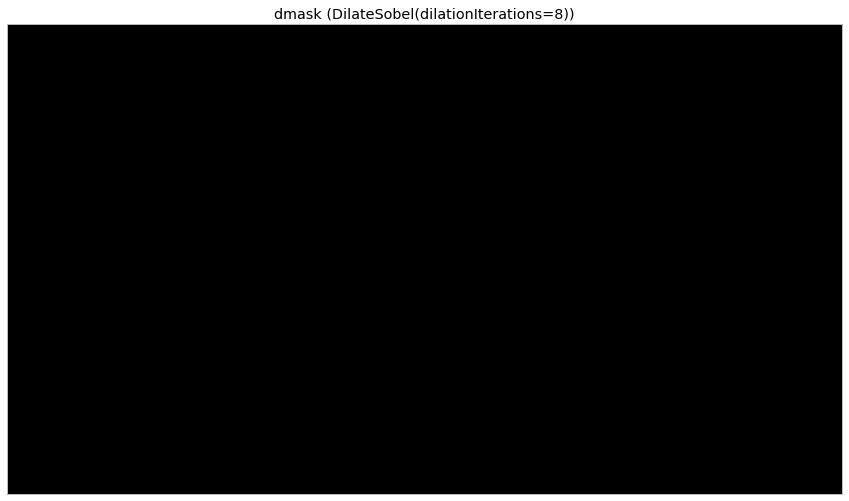

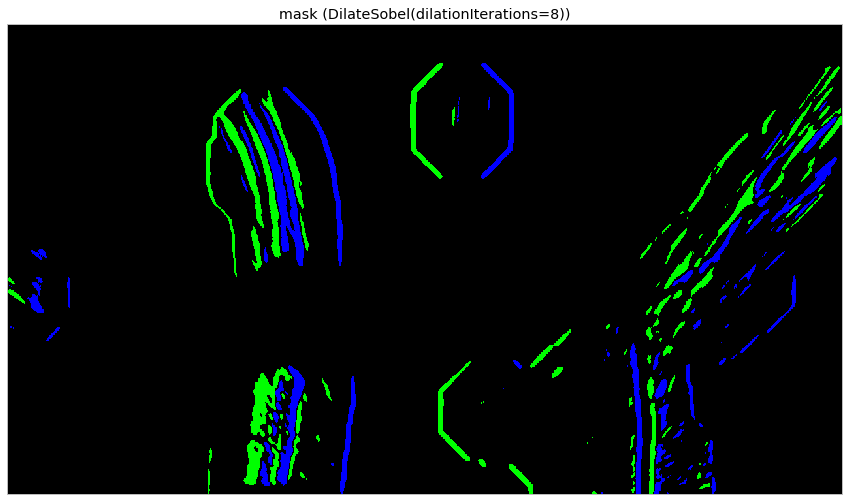

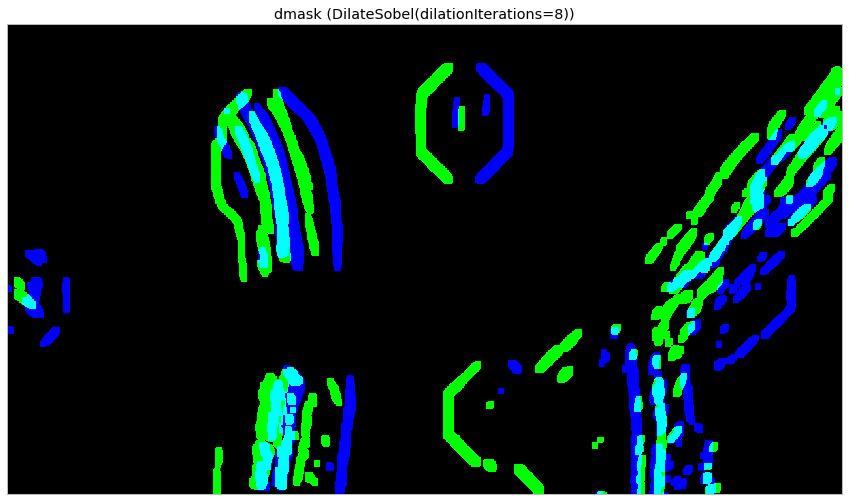

In [8]:
for op in list(hsvshow.getByKind(ColorJoin)):
    v = op.value
    fig, ax = plt.subplots(figsize=(16,9))
    show(v, ax=ax, title=op.getSimpleName())

(0, 1000)

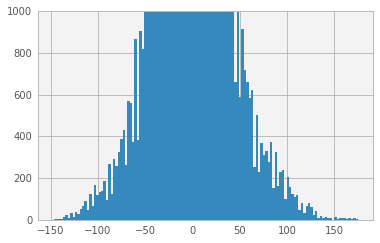

In [9]:
fig, ax = plt.subplots()
ax.hist(sobel.value.ravel(), bins=128);
ax.set_ylim(0, 1000)

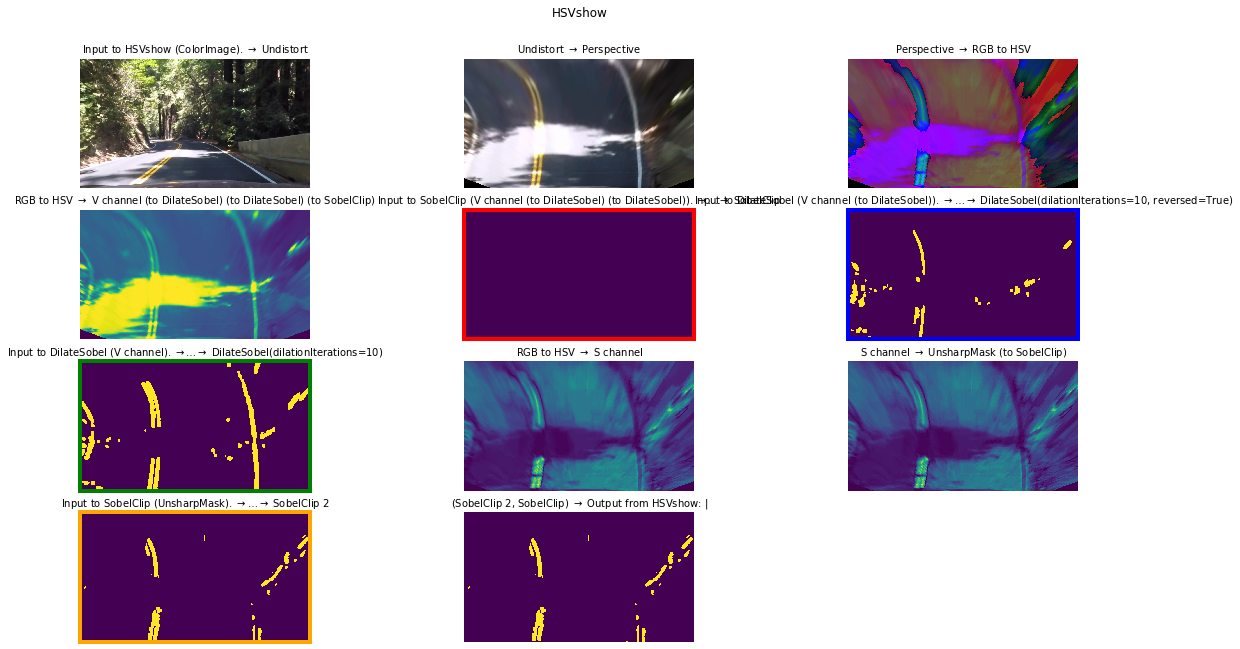

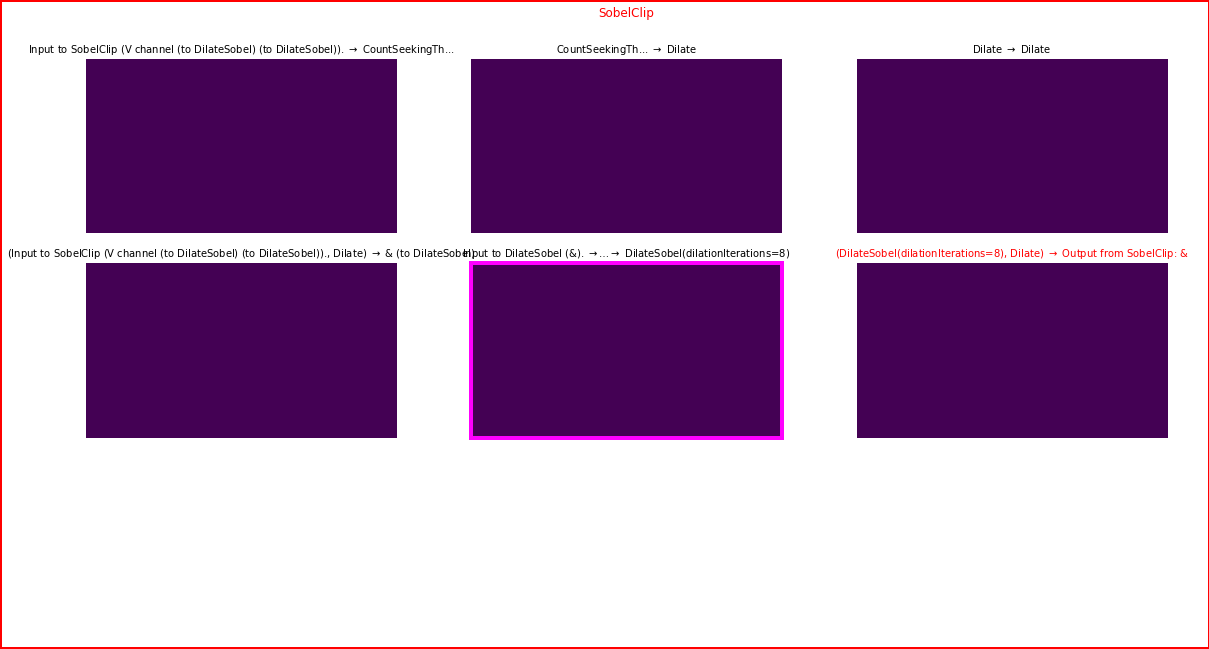

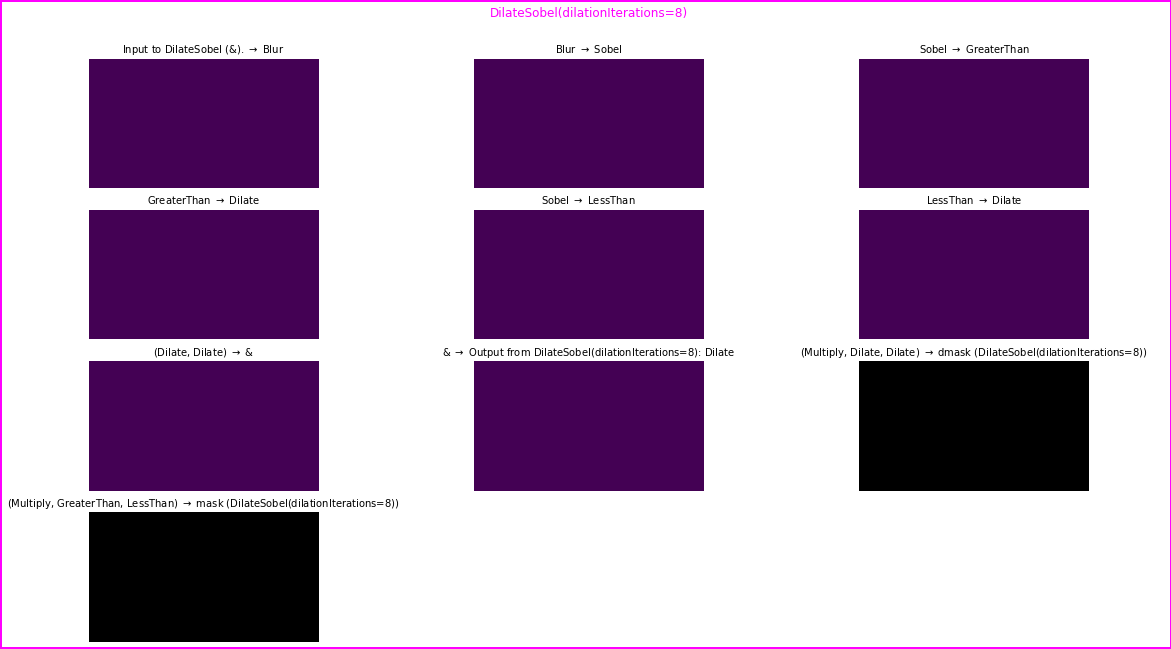

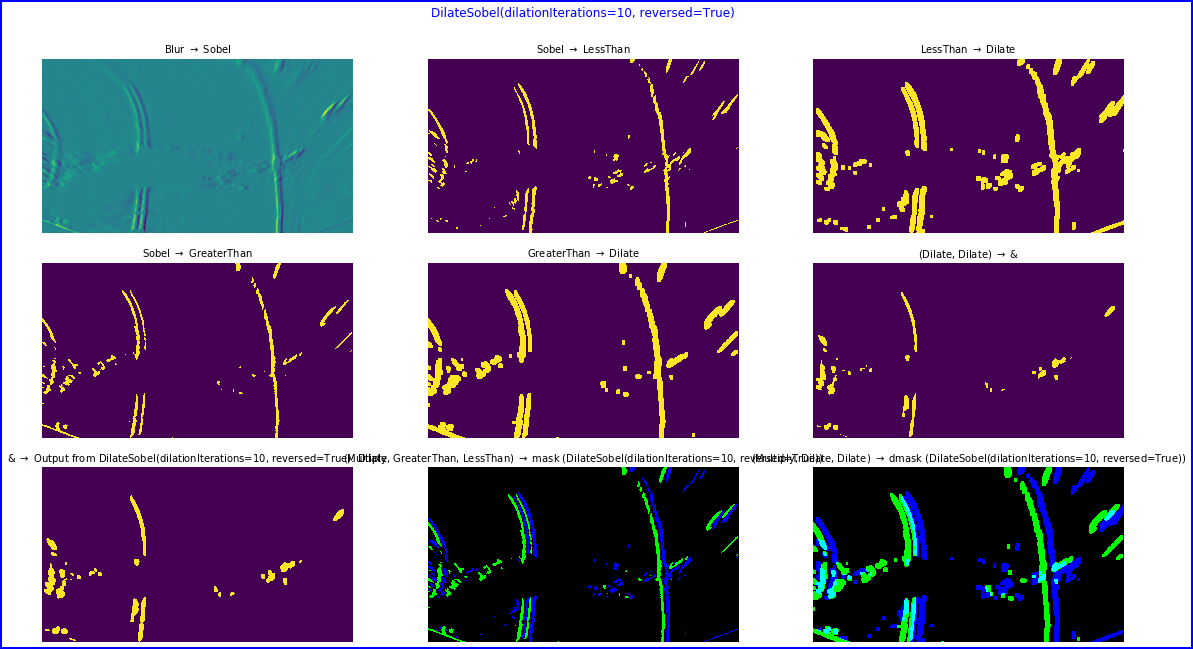

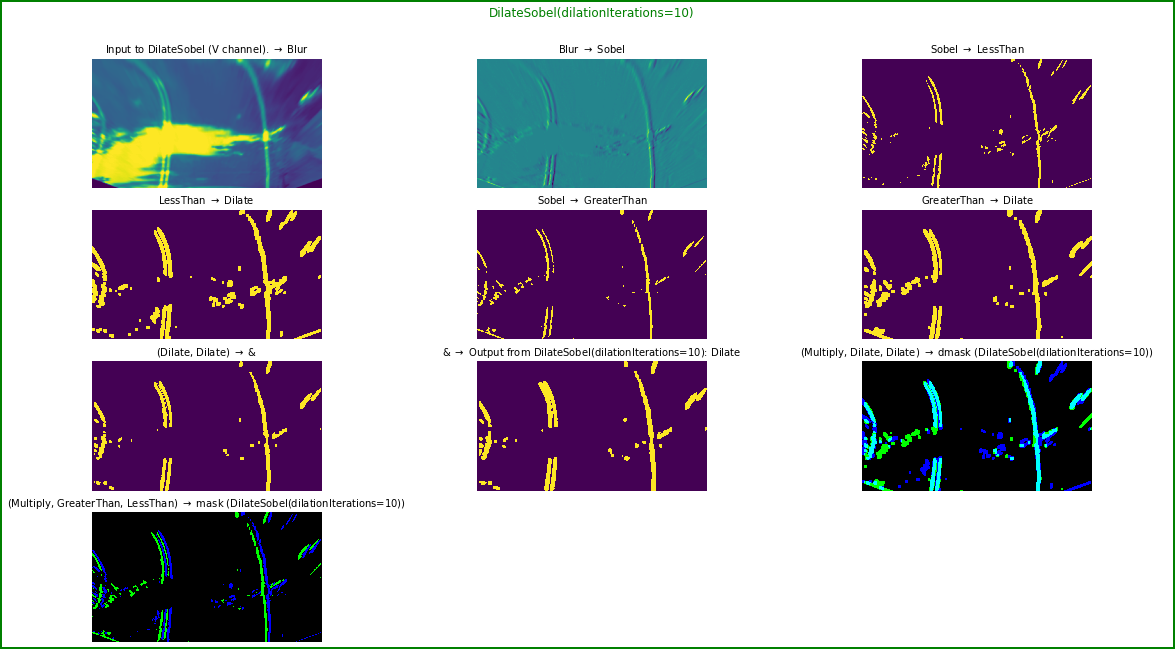

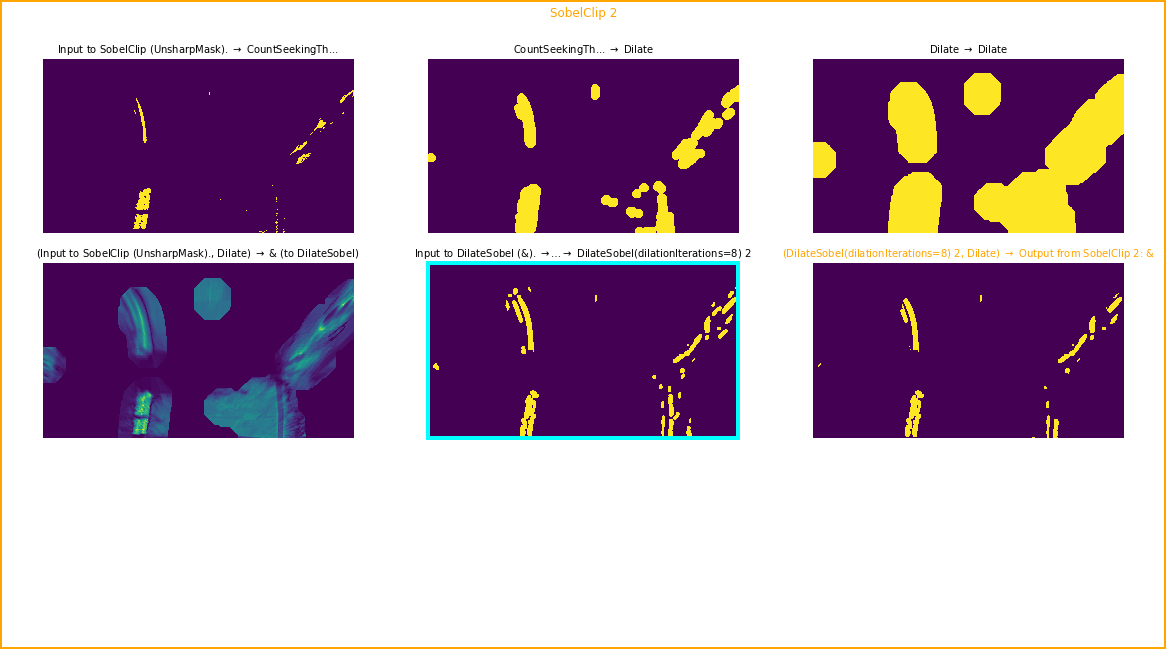

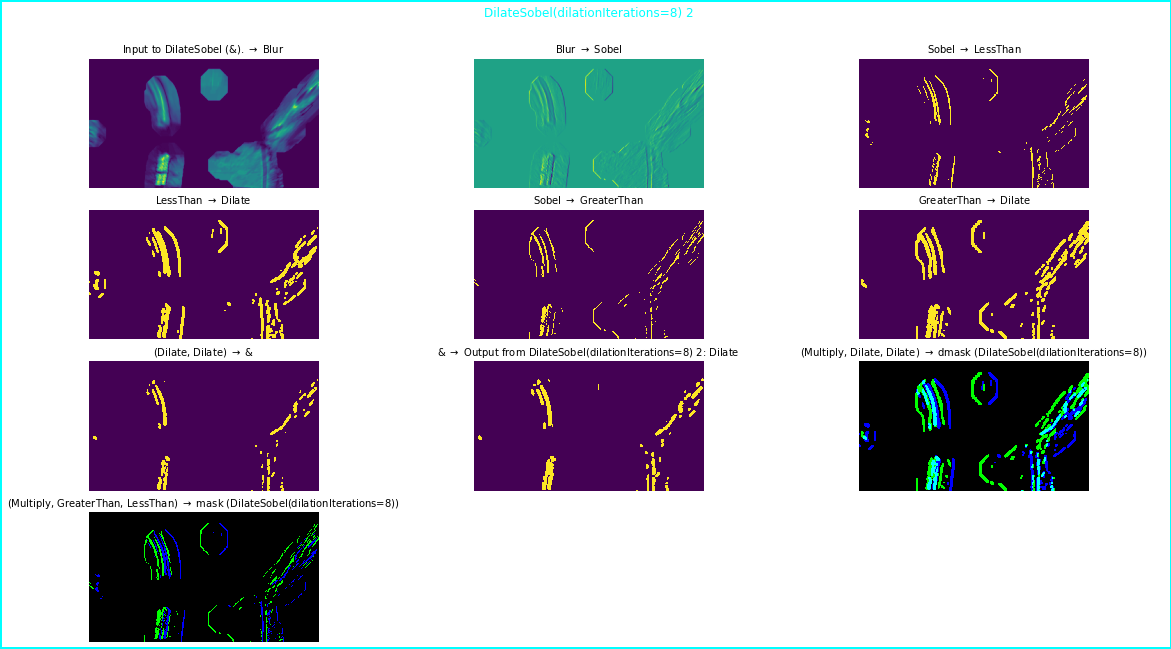

In [10]:
hsvshow.showMembers(
    subplotKwargs=dict(figsize=(16,9)), 
    wspace=0, showMultistepParents=True
)